In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [69]:
cd "/content/gdrive/MyDrive/FYP"

/content/gdrive/MyDrive/FYP


In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from PIL import Image
from torchsummary import summary

# Class Radiography Dataset

In [71]:
class RadiographyDataset(Dataset):

    def __init__(self, root, transform=None):
        super().__init__()
        self.data = []
        self.labels = []
        self.transform = transform
        self.classes   = os.listdir(root)

        #get the training samples
        for class_id, cls in enumerate(self.classes):

          cls_folder = os.path.join(root, cls)

          #get the training samples for the class 'cls'
          for img_name in os.listdir(cls_folder):
            self.data.append(os.path.join(cls_folder, img_name))
            self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        # get the image
        image = Image.open(self.data[idx])
        image = image.convert('RGB')
        
        # perform transformation
        if self.transform is not None:
          image = self.transform(image)
        
        # get the label
        label = self.labels[idx]
        
        return image, label

# Customizable BLOCK Module

In [72]:
class BLOCK(nn.Module):

    # ... define the init layer ...
    def __init__(self, blk_cin, blk_cout):

        super().__init__()

        # ... define the convolutional layers ... 
        self.conv1 = nn.Conv2d(blk_cin, blk_cout, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(blk_cout, blk_cout, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        # ...  forward propagation ... 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

In [73]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # ... define block 1 ...
        self.conv_block1 = BLOCK(3, 32)

        # ... define block 2 ...
        self.conv_block2 = BLOCK(32, 64)

        # ... define block 3 ...
        self.conv_block3 = BLOCK(64, 128)

        # ... define block 4 ...
        self.conv_block4 = BLOCK(128, 256)

        self.dropout     = nn.Dropout2d(p=0.5) 
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))      
        self.flatten     = nn.Flatten() 
        self.fc1         = nn.Linear(256, 10)
        self.fc2         = nn.Linear(10, 3)
        
    def forward(self, x):
        
        # ... block 1 ...
        x = self.conv_block1(x)
        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        # dropout
        x = self.dropout(x)
        
        # ... block 2 ...
        x = self.conv_block2(x)
        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        # dropout
        x = self.dropout(x)

        # ... block 3 ...
        x = self.conv_block3(x)
        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        # dropout
        x = self.dropout(x)

        # ... block 4 ...
        x = self.conv_block4(x)
        
        # global pool
        x = self.global_pool(x)
        
        # flatten
        x = self.flatten(x)
        
        # fc1
        x = self.fc1(x)

        # fc2
        x = self.fc2(x)
        
        return x

# Train Model

In [74]:
def train(model, trainloader, valloader, num_epochs, lr=0.01, momentum=0.9, step_size=10, gamma=0.1):
    
    if torch.cuda.is_available():
      device = torch.device("cuda")
      
    else:
      device = torch.device("cpu")
    
    # transfer model to GPU
    model = model.to(device)
    
    # set the optimizer. Use the SGD optimizer. Use the lr and momentum settings passed by the user
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # variables
    best_loss = np.inf
    saturate_count = 0
    train_history = []  # save the train loss
    val_history = []    # save the validation loss
    train_acc_history = []  # save the train accuracy
    val_acc_history = []    # save the validation accuracy
    
    # train the network
    for e in range(num_epochs):    

        #running_loss
        running_loss = 0.0
        running_count = 0.0
        running_val_loss = 0.0
        running_val_count = 0.0

        # running_correct
        running_corrects = 0
        running_val_corrects = 0

        #----------------------------train---------------------------------------
        # set to training mode
        model.train()

        # for all batch samples
        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to zero
            optimizer.zero_grad()

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss 
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get gradients of all parameters
            loss.backward()

            # update parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

            # disable gradient computation
            with torch.no_grad():

              # perform inference
              outputs = model(inputs)

              # predict as the best result  
              _, predicted = torch.max(outputs, 1)

              running_corrects += (labels == predicted).double().sum()

        # compute the averaged loss in each epoch
        train_loss = running_loss / running_count
        train_history.append(train_loss)
        running_loss = 0. 
        running_count = 0.  

        # Update the scheduler's counter at the end of each epoch
        scheduler.step()

        # compute the averaged accuracy in each epoch
        train_acc = 100*running_corrects/len(trainloader.dataset)
        train_acc_history.append(train_acc.item())

        #-----------------------validation---------------------------------------
        # set to eval mode
        model.eval()

        for i, (inputs, labels) in enumerate(valloader):

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss 
            loss_val = F.cross_entropy(outs, labels)

            # get the loss
            running_val_loss += loss_val.item()
            running_val_count += 1

            # disable gradient computation
            with torch.no_grad():

              # perform inference
              outputs = model(inputs)

              # predict as the best result  
              _, predicted = torch.max(outputs, 1)

              running_val_corrects += (labels == predicted).double().sum()

        # compute the averaged loss in each epoch
        val_loss = running_val_loss / running_val_count
        val_history.append(val_loss)
        running_val_loss = 0. 
        running_val_count = 0.

        # compute the averaged accuracy in each epoch
        val_acc = 100*running_val_corrects/len(valloader.dataset)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {e+1:2d}/{num_epochs:d} : train_loss = {train_loss:.4f} | val_loss = {val_loss:.4f}' + ' ------- train_acc = {:.2f}%'.format(train_acc) + ' | val_acc = {:.2f}%'.format(val_acc))

        # create save model folder
        if not os.path.exists("./custom_models"):
          os.mkdir("custom_models") 

        # save the model       
        checkpoint_file = './custom_models/saved_model.pt'
        torch.save({
            'epoch': e,
            'loss': train_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_file)       
                
    print("Training completed.")
    return train_history, val_history, train_acc_history, val_acc_history

# Evaluate Model

In [75]:
def evaluate(model, testloader):

    # set to evaluation mode
    model.eval() 

    # running_correct
    running_corrects = 0

    acc = 0

    # Repeat for all batch data in the test set
    for inputs, targets in testloader:

        # transfer to the GPU
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()

        # # disable gradient computation
        with torch.no_grad():
            
            # perform inference
            outputs = model(inputs)

            # predict as the best result  
            _, predicted = torch.max(outputs, 1)

            running_corrects += (targets == predicted).double().sum()
    
    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(testloader.dataset)))

# Loss graph

In [76]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss)+1)
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.ylabel('Loss', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Loss vs epochs', fontsize=18)
    plt.legend()
    plt.show()
    

# Accurarcy graph

In [77]:
def plot_history_acc(train_acc, val_acc):
    epochs = range(1, len(train_acc)+1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_acc, color='red', label='train_acc')
    plt.plot(epochs, val_acc, color='blue', label='val_acc')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()

Check the dataset images number

In [78]:
classes = ['COVID', 'Normal', 'Viral Pneumonia']

total_ori = 0
ori_path = './COVID-19_Radiography_Dataset/'
for cls in classes:
  total_ori += len(os.listdir(ori_path + cls + '/images'))
print('Total of original datasets         : ', total_ori)
print('---------------------------------------------\n')

print('Train-Covid                        : ', len(os.listdir('./Radiography_Data/train/COVID')))
print('Train-Normal                       : ', len(os.listdir('./Radiography_Data/train/Normal')))
print('Train-Viral Pneumonia              : ', len(os.listdir('./Radiography_Data/train/Viral Pneumonia')))

print('\nValidation-Covid                   : ', len(os.listdir('./Radiography_Data/val/COVID')))
print('Validation-Normal                  : ', len(os.listdir('./Radiography_Data/val/Normal')))
print('Validation-Viral Pneumonia         : ', len(os.listdir('./Radiography_Data/val/Viral Pneumonia')))

print('\nTest-Covid                         : ', len(os.listdir('./Radiography_Data/test/COVID')))
print('Test-Normal                        : ', len(os.listdir('./Radiography_Data/test/Normal')))
print('Test-Viral Pneumonia               : ', len(os.listdir('./Radiography_Data/test/Viral Pneumonia')))

print('---------------------------------------------\n')
new_path = './Radiography_Data/'
folder = ['train', 'val', 'test']
total_new = 0
for fld in folder:
  for cls in classes:
    total_new += len(os.listdir(new_path + fld + '/' + cls))

print('Total of Train, Val, Test datasets : ', total_new)

Total of original datasets         :  15153
---------------------------------------------

Train-Covid                        :  2892
Train-Normal                       :  8153
Train-Viral Pneumonia              :  1076

Validation-Covid                   :  362
Validation-Normal                  :  1019
Validation-Viral Pneumonia         :  134

Test-Covid                         :  362
Test-Normal                        :  1020
Test-Viral Pneumonia               :  135
---------------------------------------------

Total of Train, Val, Test datasets :  15153


Show the sample images

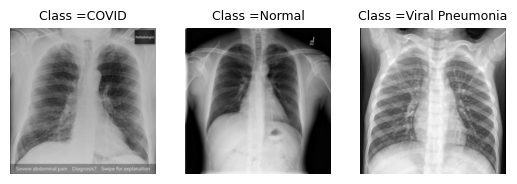

In [79]:
sampleset = RadiographyDataset("./Radiography_Data/train", transform=None)

image_1, label_1 = sampleset[1]
image_2, label_2 = sampleset[2893]
image_3, label_3 = sampleset[11047]

plt.subplot(1, 3, 1)
plt.imshow(image_1)
plt.title('Class =' + sampleset.classes[label_1], fontsize=9)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_2)
plt.title('Class =' + sampleset.classes[label_2], fontsize=9)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_3)
plt.title('Class =' + sampleset.classes[label_3], fontsize=9)
plt.axis('off')

plt.show()

The network layout

In [80]:
if torch.cuda.is_available():
  device = torch.device("cuda")
      
else:
  device = torch.device("cpu")
    
sample_net = Net()
sample_net = sample_net.to(device)
summary(sample_net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]           9,248
             BLOCK-3         [-1, 32, 224, 224]               0
         Dropout2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
            Conv2d-6         [-1, 64, 112, 112]          36,928
             BLOCK-7         [-1, 64, 112, 112]               0
         Dropout2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
           Conv2d-10          [-1, 128, 56, 56]         147,584
            BLOCK-11          [-1, 128, 56, 56]               0
        Dropout2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
           Conv2d-14          [-1, 256,

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


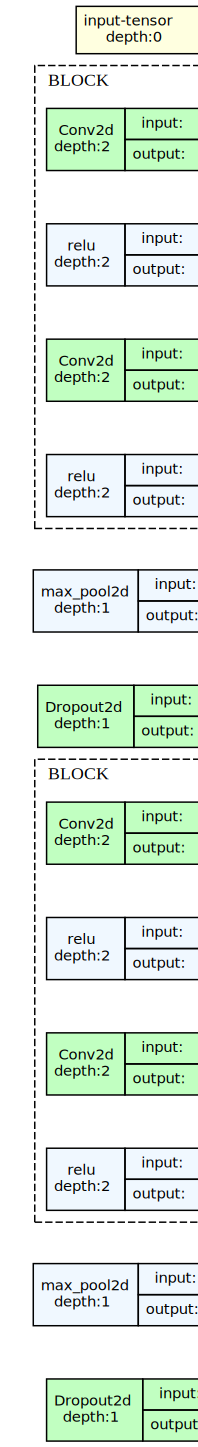

In [81]:
!pip install torchview
import torchvision
from torchview import draw_graph

model_graph = draw_graph(sample_net, input_size=(4,3,224,224), expand_nested=True)
model_graph.visual_graph

# Transformation of Images

In [82]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
train_transform = transforms.Compose([
    transforms.Resize(256),                                # output: PIL Image of resolution(256, 256)
    transforms.RandomCrop(224),                            # output: PIL Image of resolution(224, 224)
    transforms.RandomHorizontalFlip(),                     # output: PIL Image of resolution(224, 224)
    transforms.ToTensor(),                                 # output: tensor, dtype = float32, shape = (3, 224, 224), range:[0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # output: same as before except range changes such that mean = 0, std = 1
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Load the dataset using DataLoader

In [83]:
#Load the dataset
trainset = RadiographyDataset("./Radiography_Data/train", transform=train_transform)
valset  = RadiographyDataset("./Radiography_Data/val", transform=val_transform)

batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader  = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

Start training

In [84]:
# Release Cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [85]:
net = Net()
train_loss, val_loss, train_acc, val_acc = train (net, trainloader, valloader, num_epochs=50)

Epoch  1/50 : train_loss = 0.8359 | val_loss = 0.8255 ------- train_acc = 66.69% | val_acc = 67.26%
Epoch  2/50 : train_loss = 0.8248 | val_loss = 0.8225 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  3/50 : train_loss = 0.8242 | val_loss = 0.8203 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  4/50 : train_loss = 0.8246 | val_loss = 0.8241 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  5/50 : train_loss = 0.8245 | val_loss = 0.8304 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  6/50 : train_loss = 0.8241 | val_loss = 0.8242 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  7/50 : train_loss = 0.8153 | val_loss = 0.7976 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  8/50 : train_loss = 0.8076 | val_loss = 0.8055 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  9/50 : train_loss = 0.8017 | val_loss = 0.7912 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch 10/50 : train_loss = 0.7446 | val_loss = 0.7040 ------- train_acc = 68.01% | val_acc = 69.17%


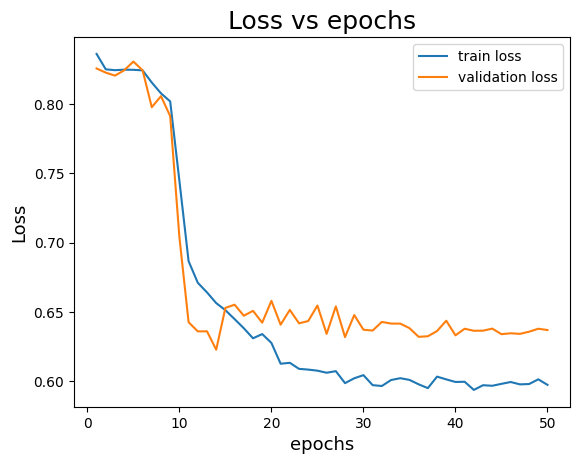

In [86]:
plot_loss(train_loss, val_loss)

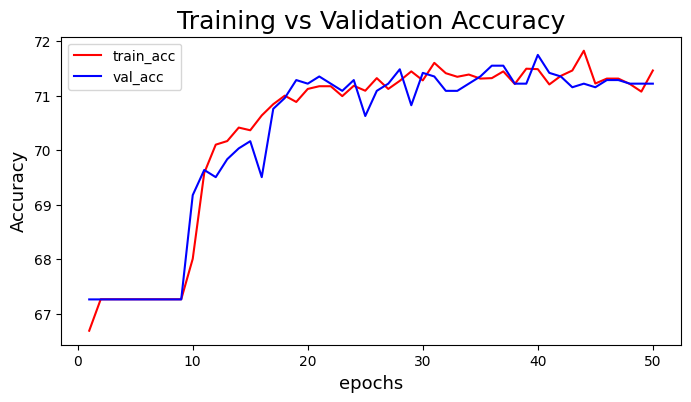

In [87]:
plot_history_acc(train_acc, val_acc)

Evaluate model

In [88]:
# transform the model
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32
testset = RadiographyDataset("./Radiography_Data/test", transform=test_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [89]:
evaluate(net, testloader)

Accuracy = 70.67%
